In [4]:
import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymanopt.manifolds import Stiefel
from pymanopt import Problem
from pymanopt.optimizers import TrustRegions
import pymanopt

X_train = pd.read_csv('data/X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv('data/Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

In [5]:
X_train.head()

date,0,1,2,3,4,5,6,7,8,9,...,744,745,746,747,748,749,750,751,752,753
stocksID,,,,,,,,,,,,,,,,,,,,,
0,-0.018647,-0.013002,-0.010776,-0.016676,-0.005110,0.009092,-0.011745,0.007120,-0.008451,0.009119,...,-0.012525,-0.011716,0.003532,0.009965,0.018142,-0.001236,-0.002732,0.013074,-0.005843,-0.003823
1,-0.008254,-0.022280,0.012173,-0.006820,-0.004055,0.012912,-0.001293,0.009994,-0.002747,0.001664,...,0.014432,-0.002255,-0.011493,0.002291,-0.001346,-0.004026,-0.004672,-0.002889,-0.004984,0.005005
2,-0.008404,-0.013629,-0.006044,-0.003425,-0.009522,-0.001353,-0.000637,0.007640,0.001600,0.007416,...,-0.006245,-0.001329,0.005230,0.003510,0.006022,-0.000343,0.001757,0.004972,0.004916,-0.007338
3,-0.022734,-0.006981,-0.008568,-0.010899,-0.017981,0.002485,-0.011980,0.012446,-0.010636,0.003807,...,-0.005179,-0.003442,0.002733,0.013369,0.019738,0.001201,-0.003669,0.008690,0.000272,-0.008150
4,-0.024546,-0.008315,-0.007991,-0.003515,0.007872,0.007082,-0.004614,-0.008182,-0.005255,0.014404,...,-0.017507,-0.001233,-0.000552,0.004664,0.005202,0.007695,0.003775,0.005097,0.001135,-0.009262


In [6]:
print(np.isnan(X_train.values).sum())

0


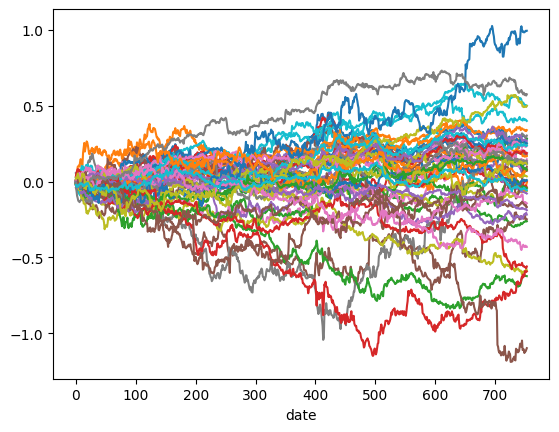

In [7]:
# The cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.cumsum().plot(legend=False)
plt.show()

##### A useful data representation:

To speed up upcoming computations, we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

In [8]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis = 1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

/tmp/ipykernel_99662/746006316.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis = 1).dropna()
/tmp/ipykernel_99662/746006316.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis = 1).dropna()
/tmp/ipykernel_99662/746006316.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for p

The motivation is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

In [9]:
X_train_reshape

timeLag             1         2         3         4         5         6    \
date stocksID                                                               
250  0         0.000103  0.012387  0.011243  0.002595 -0.008509 -0.002711   
     1        -0.000982  0.003932  0.000050  0.001616 -0.003902 -0.001686   
     2         0.009301  0.003914  0.004995  0.001539  0.001452  0.002809   
     3         0.006515 -0.006553  0.009464  0.005204  0.004227 -0.005438   
     4        -0.006223  0.005415  0.014643  0.005195  0.004489  0.002695   
...                 ...       ...       ...       ...       ...       ...   
753  45        0.009786 -0.001861  0.012294 -0.023981  0.004069  0.000148   
     46       -0.008842  0.003698  0.005138 -0.004295 -0.010509  0.010230   
     47       -0.008607  0.006122 -0.007828 -0.008224  0.011357 -0.012855   
     48       -0.007519  0.001956  0.001903  0.001535  0.000695  0.004107   
     49       -0.002816 -0.002696 -0.007145 -0.001814  0.004331  0.005457   

timeLag             7         8         9         10   ...       241  \
date stocksID                                          ...             
250  0         0.008934  0.006571 -0.018546 -0.008353  ...  0.009119   
     1         0.008810  0.001585 -0.000745 -0.002155  ...  0.001664   
     2         0.005177 -0.006942 -0.013340 -0.008071  ...  0.007416   
     3         0.008861  0.004025 -0.012432 -0.006100  ...  0.003807   
     4         0.007609  0.011437 -0.004804  0.039274  ...  0.014404   
...                 ...       ...       ...       ...  ...       ...   
753  45       -0.062300  0.040002 -0.003475 -0.016284  ...  0.003808   
     46        0.006846  0.017514 -0.010796 -0.026356  ... -0.012077   
     47        0.000346 -0.016681  0.008247 -0.002723  ...  0.007291   
     48       -0.011879  0.000526  0.003178 -0.010654  ...  0.010960   
     49        0.000633 -0.005819  0.007592 -0.002003  ... -0.024003   

timeLag             242       243       244       245       246       247  \
date stocksID                                                               
250  0        -0.008451  0.007120 -0.011745  0.009092 -0.005110 -0.016676   
     1        -0.002747  0.009994 -0.001293  0.012912 -0.004055 -0.006820   
     2         0.001600  0.007640 -0.000637 -0.001353 -0.009522 -0.003425   
     3        -0.010636  0.012446 -0.011980  0.002485 -0.017981 -0.010899   
     4        -0.005255 -0.008182 -0.004614  0.007082  0.007872 -0.003515   
...                 ...       ...       ...       ...       ...       ...   
753  45       -0.003027  0.002522 -0.006594 -0.000489  0.054751 -0.012180   
     46       -0.002215  0.027569  0.021476  0.003874 -0.001690  0.012346   
     47        0.000369  0.000962 -0.005902  0.001067  0.013055  0.015432   
     48       -0.012003 -0.001969  0.030976 -0.000712  0.009795 -0.006842   
     49        0.001416  0.003348 -0.003685 -0.002267 -0.006733  0.000575   

timeLag             248       249       250  
date stocksID                                
250  0        -0.010776 -0.013002 -0.018647  
     1         0.012173 -0.022280 -0.008254  
     2        -0.006044 -0.013629 -0.008404  
     3        -0.008568 -0.006981 -0.022734  
     4        -0.007991 -0.008315 -0.024546  
...                 ...       ...       ...  
753  45        0.019142 -0.023184 -0.001315  
     46        0.007502  0.011425 -0.001580  
     47        0.023533 -0.022811 -0.001053  
     48        0.000464  0.015894 -0.003321  
     49        0.000735 -0.020917 -0.004808  

[25200 rows x 250 columns]

In [10]:
def check_orthonormality(A):
    """Verify if matrix A has orthonormal columns."""
    F = A.shape[1]
    product = A.T @ A
    return np.allclose(product, np.eye(F), atol=1e-6)

def differentiable_lstsq(A, b):
    return np.linalg.pinv(A) @ b

def fit_model(R, D, F):
    """
    R: N x T array of stock returns.
    D: Number of lagged returns used.
    F: Number of factors.
    Returns optimal A (D x F), beta (F x 1).
    """
    N, T = R.shape
    Y_true = R[:, D:]  # Shape (N, T-D)
    Y_flat = Y_true.T.flatten()  # Flattened to (N*(T-D),)

    # Construct lagged returns matrix X
    X = np.zeros((N*(T-D), D))
    for n in range(N):
        for t in range(D, T):
            idx = n*(T-D) + (t-D)
            X[idx, :] = R[n, t-D:t][::-1]  # Use past D returns

    X = np.array(X)  # Use autograd.numpy
    
    # Define optimization problem on Stiefel manifold
    manifold = Stiefel(D, F)
    solver = TrustRegions()

    @pymanopt.function.autograd(manifold)
    def objective(A):
        if not check_orthonormality(A):
            return 1.0  # Penalize non-orthonormal A
    
        A = np.array(A)  # Use autograd.numpy   
        # Compute factors and beta via least squares
        F_mat = X @ A  # (N*(T-D), F)
        beta = differentiable_lstsq(F_mat, Y_flat)
        
        # Compute predicted returns
        Y_pred_flat = F_mat @ beta
        Y_pred = Y_pred_flat.reshape((N, T-D))
        
        # Normalize columns (time steps)
        norm_true = np.sqrt(np.sum(Y_true**2, axis=0)) + 1e-10
        norm_pred = np.sqrt(np.sum(Y_pred**2, axis=0)) + 1e-10
        Y_true_norm = Y_true / norm_true
        Y_pred_norm = Y_pred / norm_pred
        
        # Compute mean overlap
        overlap = np.sum(Y_true_norm * Y_pred_norm, axis=0)
        mean_overlap = np.mean(overlap)
        return -mean_overlap  # Minimize negative overlap

    problem = Problem(manifold=manifold, cost=objective)
    A_opt = solver.run(problem)

    print(np.shape(A_opt))
    print("A_opt:", A_opt)

    return Y_flat, X, A_opt

In [11]:
Y_flat, X, A_opt = fit_model(X_train.values, D=250, F = 10)

Optimizing...
                                            f: +3.888598e-05   |grad|: 1.985772e-01
acc       k:     1     num_inner:     0     f: -4.089580e-02   |grad|: 1.550998e-01   exceeded trust region
acc       k:     2     num_inner:     0     f: -8.078768e-02   |grad|: 1.474248e-01   exceeded trust region
acc       k:     3     num_inner:     1     f: -9.586835e-02   |grad|: 1.933759e-01   exceeded trust region
acc       k:     4     num_inner:     1     f: -1.075228e-01   |grad|: 1.739668e-01   negative curvature
acc TR-   k:     5     num_inner:     1     f: -1.138502e-01   |grad|: 1.673992e-01   negative curvature
acc TR+   k:     6     num_inner:     0     f: -1.271539e-01   |grad|: 1.061993e-01   exceeded trust region
acc       k:     7     num_inner:     0     f: -1.316034e-01   |grad|: 1.288785e-01   exceeded trust region
acc TR-   k:     8     num_inner:     1     f: -1.336299e-01   |grad|: 1.980433e-01   exceeded trust region
acc TR+   k:     9     num_inner:     0     

In [12]:
A_opt = np.array(A_opt.point)

In [13]:
np.save("A_opt.npy", A_opt)  # Saves as a binary .npy file
np.save("X.npy", X)
np.save("Y_flat.npy", Y_flat)
#np.load("A_opt.npy", A_opt)

In [14]:
np.shape(A_opt)

(250, 10)

In [15]:
# Fit final beta
F_mat_opt = X @ A_opt
beta_opt = np.linalg.lstsq(F_mat_opt, Y_flat, rcond=None)[0]

In [16]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap  

In [17]:
def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

In [18]:
# from output to csv file...
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv('submissionExample.csv')

NameError: name 'A' is not defined